In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import gtsam
from gtsam import Pose2
import gtsam.utils.plot as gtsam_plot
import cv2
import import_ipynb
# from Image_Registration_Part_1 import *
import os
import random
from scipy.optimize import least_squares
import itertools

### Step-1: Image Preprocessing and Normalization

In [22]:
#MY CODE FROM PART-1


def load_images_from_folder(folder_path): 
    """
    Load all images from the specified folder.
    """
    images = [] 
    image_files = [file for file in os.listdir(folder_path) if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tif'))]
        
    if not image_files:
        raise ValueError(f"No images found in the folder: {folder_path}")
    
    for filename in image_files:
        img_path = os.path.join(folder_path, filename)
        image = cv2.imread(img_path)
        if image is not None:
            images.append((filename, image))
        else:
            print(f"Warning: {filename} could not be loaded.")
    
    return images

In [3]:
def normalize_image(image):
    """
    Normalize the image using initial normalization, grayscale conversion, and CLAHE.
    """
    # Initial Normalization to spread the pixel intensities over the full range [0, 255]
    pixel_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    # Convert to grayscale if the image is in color (3 channels)
    if len(pixel_image.shape) == 3:
        pixel_image_convert = cv2.cvtColor(pixel_image, cv2.COLOR_BGR2GRAY)
    
    # CLAHE (Contrast Limited Adaptive Histogram Equalization) - Local Contrast Enhancement
    clahe = cv2.createCLAHE()
    clahe_image = clahe.apply(pixel_image_convert)
    
    return clahe_image, pixel_image

In [4]:
# Replace with the path to your folder containing images
folder_path = '29images'
images = load_images_from_folder(folder_path)

# Process and plot each image
for filename, image in images:
    clahe_image, normalized_image = normalize_image(image)

### Step-2: SIFT: Extracting Keypoints and Descriptors

In [5]:
#MY CODE FROM PART-1

def detect_and_describe_features(image):
    """
    Detect keypoints and compute descriptors using SIFT with adjusted parameters.
    """
    # Initialize the SIFT detector with custom parameters
    sift = cv2.SIFT_create(nfeatures=5000, contrastThreshold=0.025, edgeThreshold=10, nOctaveLayers=16, sigma=1.8)
    
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    print(f"Detected {len(keypoints)} keypoints.")
    return keypoints, descriptors

In [6]:
# Set seeds for reproducibility
np.random.seed(42)  # Seed for NumPy operations
cv2.setRNGSeed(42)  # Seed for OpenCV operations
random.seed(42)     # Seed for Python random operations

keypoint_store = []
descriptor_store = []

normalized = []
pixel = []

# Process and plot each image
for filename, image in images:
    
    clahe_image, normalized_image = normalize_image(image) 
    normalized.append(clahe_image)
    pixel.append(normalized_image)   

    # Detect and describe features on the normalized image
    keypoints, descriptors = detect_and_describe_features(clahe_image)

    keypoint_store.append(np.array(keypoints))
    descriptor_store.append(np.array(descriptors))

Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5001 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5001 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5002 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5001 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5001 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.
Detected 5000 keypoints.


### Step-3: Feature Matching using FLANN

In [7]:
#MY CODE FROM PART-1:


def match_features(descriptors1, descriptors2, keypoints1, keypoints2):
    """
    Match features between two sets of descriptors using FLANN-based matcher.
    """
    # Set seeds for reproducibility
    np.random.seed(42)  # Seed for NumPy operations
    cv2.setRNGSeed(42)  # Seed for OpenCV operations
    random.seed(42)     # Seed for Python random operations
    
    # Define FLANN-based matcher parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)  # Higher number of checks for better precision
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    # Match descriptors using KNN approach
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
    # Filter matches using the ratio test
    good_matches = []
    src_pts = []
    dst_pts = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)
            src_pts.append(keypoints1[m.queryIdx].pt)
            dst_pts.append(keypoints2[m.trainIdx].pt)

    print(f"Found {len(good_matches)} good matches.")
    return np.array(src_pts), np.array(dst_pts)

In [8]:
# # Match features between the two images
# collected_matches = match_keypoints_across_images(keypoint_store, descriptor_store)

# # Plot the matching results
im1=6
im2=7
print(f"Length of normalized: {len(normalized)}")
print(f"Length of pixel: {len(pixel)}")
print(f"Length of keypoint_store: {len(keypoint_store)}")
print(f"Length of descriptor_store: {len(descriptor_store)}")
print(f"Image 1 index (im1): {im1}")
print(f"Image 2 index (im2): {im2}")

src, dst = match_features(descriptor_store[im1], descriptor_store[im2], keypoint_store[im1], keypoint_store[im2])

Length of normalized: 28
Length of pixel: 28
Length of keypoint_store: 28
Length of descriptor_store: 28
Image 1 index (im1): 6
Image 2 index (im2): 7
Found 16 good matches.


### Step-4: GTSAM Noise Model and Affine Transformation Calculations

In [9]:
def extract_pose_and_verify_distance(pose_a, pose_b, transformation=None, distance_threshold=None):
    """
    Extracts a GTSAM pose from a transformation matrix and checks if two poses are within a certain distance.
    """
    computed_pose = None
    if transformation is not None:
        angle = np.arctan2(transformation[1, 0], transformation[0, 0])
        computed_pose = gtsam.Pose2(transformation[0, 2], transformation[1, 2], angle)

    if distance_threshold is not None and pose_a is not None and pose_b is not None:
        distance = cv2.norm(pose_a.translation() - pose_b.translation())
        is_within_distance = distance < distance_threshold
        return is_within_distance, computed_pose

    return computed_pose


def compute_transformation_and_uncertainty(src_points, dst_points): ##REFERENCE TAKEN FROM ZHIYONG ZHANG'S CODE
    """
    Computes the affine transformation between two sets of points and estimates the uncertainty.
    """
    if src_points.shape[0] < 4:
        return None

    affine_transform, inlier_mask = cv2.estimateAffinePartial2D(src_points, dst_points)
    num_inliers = np.sum(inlier_mask)

    if num_inliers < 3:
        return None

    scale = np.linalg.norm(affine_transform[:2, 0])
    affine_transform[:2, :2] /= scale

    sigma_values = 1000 * (num_inliers ** -2) * np.array([1, 1, np.deg2rad(1)])
    noise_model = gtsam.noiseModel.Diagonal.Sigmas(sigma_values)

    homogeneous_transform = np.vstack([affine_transform, [0, 0, 1]])
    inverse_transform = np.linalg.inv(homogeneous_transform)

    return inverse_transform, noise_model

### Step-5: GTSAM Factor Graph Construction

In [10]:
def build_factor_graph(initial_poses, images, descriptors, keypoints, img_width, img_height, initial_noise_model): ##REFERENCE TAKEN FROM ZHIYONG ZHANG'S CODE
    """
    Constructs the factor graph for pose estimation using GTSAM.
    """
    graph = gtsam.NonlinearFactorGraph()
    prior_pose = gtsam.Pose2(img_width / 2, img_height / 2, 0)
    graph.add(gtsam.PriorFactorPose2(0, prior_pose, initial_noise_model))

    image_indices = range(len(images))
    for idx_i, idx_j in itertools.combinations(image_indices, 2):
        if idx_j == idx_i + 1:
            src_pts, dst_pts = match_features(
                descriptors[idx_i], descriptors[idx_j], keypoints[idx_i], keypoints[idx_j]
            )
            transform_and_noise = compute_transformation_and_uncertainty(src_pts, dst_pts)
            if transform_and_noise:
                pose = extract_pose_and_verify_distance(None, None, transformation=transform_and_noise[0])
                graph.add(gtsam.BetweenFactorPose2(idx_i, idx_j, pose, transform_and_noise[1]))
        else:
            is_within_range, _ = extract_pose_and_verify_distance(
                initial_poses.atPose2(idx_i),
                initial_poses.atPose2(idx_j),
                distance_threshold=img_width * 0.8
            )
            if is_within_range:
                src_pts, dst_pts = match_features(
                    descriptors[idx_i], descriptors[idx_j], keypoints[idx_i], keypoints[idx_j]
                )
                transform_and_noise = compute_transformation_and_uncertainty(src_pts, dst_pts)
                if transform_and_noise:
                    pose = extract_pose_and_verify_distance(None, None, transformation=transform_and_noise[0])
                    graph.add(gtsam.BetweenFactorPose2(idx_i, idx_j, pose, transform_and_noise[1]))
    return graph


def display_graph(estimated_poses, factor_graph, covariance_estimates):
    """
    Visualizes the factor graph and the estimated poses.
    """
    for idx in range(estimated_poses.size()):
        pose = estimated_poses.atPose2(idx)
        covariance = covariance_estimates.marginalCovariance(idx)
        gtsam.utils.plot.plot_pose2(0, pose, 0.5, covariance)

    for factor_idx in range(1, factor_graph.size()):
        factor = factor_graph.at(factor_idx)
        key1, key2 = factor.keys()
        pose1 = estimated_poses.atPose2(key1)
        pose2 = estimated_poses.atPose2(key2)
        plt.plot([pose1.x(), pose2.x()], [pose1.y(), pose2.y()], 'b-')

    plt.show()

In [23]:
def stitch_panorama(image_list, transform_list, canvas_size=(3000, 3000)):
    """
    Creates a panorama by stitching multiple images using the provided transformations.
    """
    canvas = np.zeros((canvas_size[0], canvas_size[1], 3), dtype=np.uint8)
    shift_center = np.array([
        [1, 0, canvas_size[0] / 2],
        [0, 1, canvas_size[1] / 2],
        [0, 0, 1]
    ])

    for image, transform in zip(image_list, transform_list):
        # Ensure image is in color
        if len(image.shape) == 2:  # Grayscale image
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        warped_image = cv2.warpPerspective(image, shift_center @ transform, canvas_size)
        canvas = np.maximum(canvas, warped_image)

    # Trim the canvas to the actual content
    non_zero_mask = np.any(canvas != 0, axis=2)
    non_zero_coords = np.argwhere(non_zero_mask)
    if non_zero_coords.size == 0:
        return None
    top_left = non_zero_coords.min(axis=0)
    bottom_right = non_zero_coords.max(axis=0)
    y_start, x_start = top_left
    y_end, x_end = bottom_right

    return canvas[y_start:y_end+1, x_start:x_end+1]

### Step-6: Factor Graph before Levenberg Marquadt Optimization

Found 374 good matches.
Found 160 good matches.
Found 58 good matches.
Found 117 good matches.
Found 28 good matches.
Found 77 good matches.
Found 16 good matches.
Found 269 good matches.
Found 282 good matches.
Found 233 good matches.
Found 301 good matches.
Found 246 good matches.
Found 15 good matches.
Found 355 good matches.
Found 271 good matches.
Found 425 good matches.
Found 339 good matches.
Found 425 good matches.
Found 382 good matches.
Found 114 good matches.
Found 319 good matches.
Found 368 good matches.
Found 201 good matches.
Found 354 good matches.
Found 282 good matches.
Found 257 good matches.
Found 239 good matches.
Found 374 good matches.
Found 66 good matches.
Found 2 good matches.
Found 0 good matches.
Found 2 good matches.
Found 8 good matches.
Found 41 good matches.
Found 1 good matches.
Found 0 good matches.
Found 0 good matches.
Found 0 good matches.
Found 160 good matches.
Found 6 good matches.
Found 0 good matches.
Found 0 good matches.
Found 2 good matches.

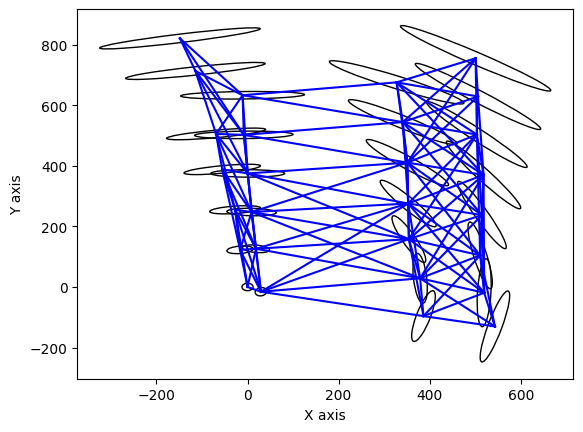

In [21]:
# Initial uncertainty model
initial_uncertainty = gtsam.noiseModel.Diagonal.Sigmas(np.array([5, 5, np.deg2rad(5)]))
initial_estimates = gtsam.Values()

# Get image dimensions
img_width, img_height = pixel[0].shape[1], pixel[0].shape[0]

# Initialize cumulative transformation and initial pose
cumulative_transform = np.eye(3)
initial_estimates.insert(0, gtsam.Pose2())

# Build initial estimates for poses
for i in range(len(pixel) - 1):
    
    # Match features between consecutive images
    origin_pts, target_pts = match_features(
        descriptor_store[i],
        descriptor_store[i + 1],
        keypoint_store[i],
        keypoint_store[i + 1]
    )
    # Compute transformation and uncertainty
    transform, _ = compute_transformation_and_uncertainty(origin_pts, target_pts)
    if transform is None:
        continue  # Skip if transformation could not be computed
    # Update cumulative transformation
    cumulative_transform = transform @ cumulative_transform
    # Extract pose from cumulative transformation
    extracted_pose = extract_pose_and_verify_distance(None, None, transformation=cumulative_transform)
    initial_estimates.insert(i + 1, extracted_pose)

# Build the factor graph using the updated function
factor_graph = build_factor_graph(
    initial_poses=initial_estimates,
    images=pixel,
    descriptors=descriptor_store,
    keypoints=keypoint_store,
    img_width=img_width,
    img_height=img_height,
    initial_noise_model=initial_uncertainty
)

# Compute marginals for initial estimates
uncertainties = gtsam.Marginals(factor_graph, initial_estimates)

# Visualize the initial graph
display_graph(initial_estimates, factor_graph, uncertainties)

### Step-7: Factor Graph after Levenberg Marquadt Optimization

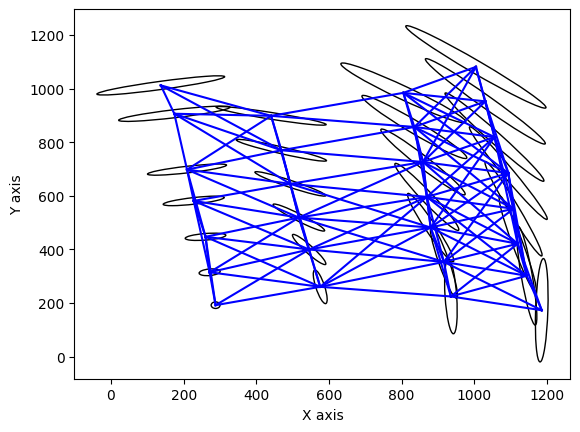

In [19]:
# Optimize the factor graph
optimization_params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(factor_graph, initial_estimates, optimization_params)
optimized_estimates = optimizer.optimize()

# Calculate marginals for uncertainty estimation after optimization
marginals = gtsam.Marginals(factor_graph, optimized_estimates)

# Visualize the optimized graph
display_graph(optimized_estimates, factor_graph, marginals)

Effects on Factor Graph before and after optimization:

1. The optimized graph shows significant horizontal expansion, with the x-axis range roughly doubling. This suggests the optimization process corrected for compression or scaling issues in the initial estimates.

2. Many uncertainty ellipses in the optimized graph appear smaller and reoriented, indicating reduced positional uncertainty and better alignment with the scene's structure.

3. Despite substantial node repositioning, the overall connection pattern and topology of the graph are preserved, demonstrating that the optimization respected fundamental image relationships.

4. The optimization unfolded the graph, spreading out nodes and connections. This resulted in a clearer visualization of the camera positions and their relationships, likely representing a more accurate reconstruction of the scene structure.

### Step-8: Final Mosaic

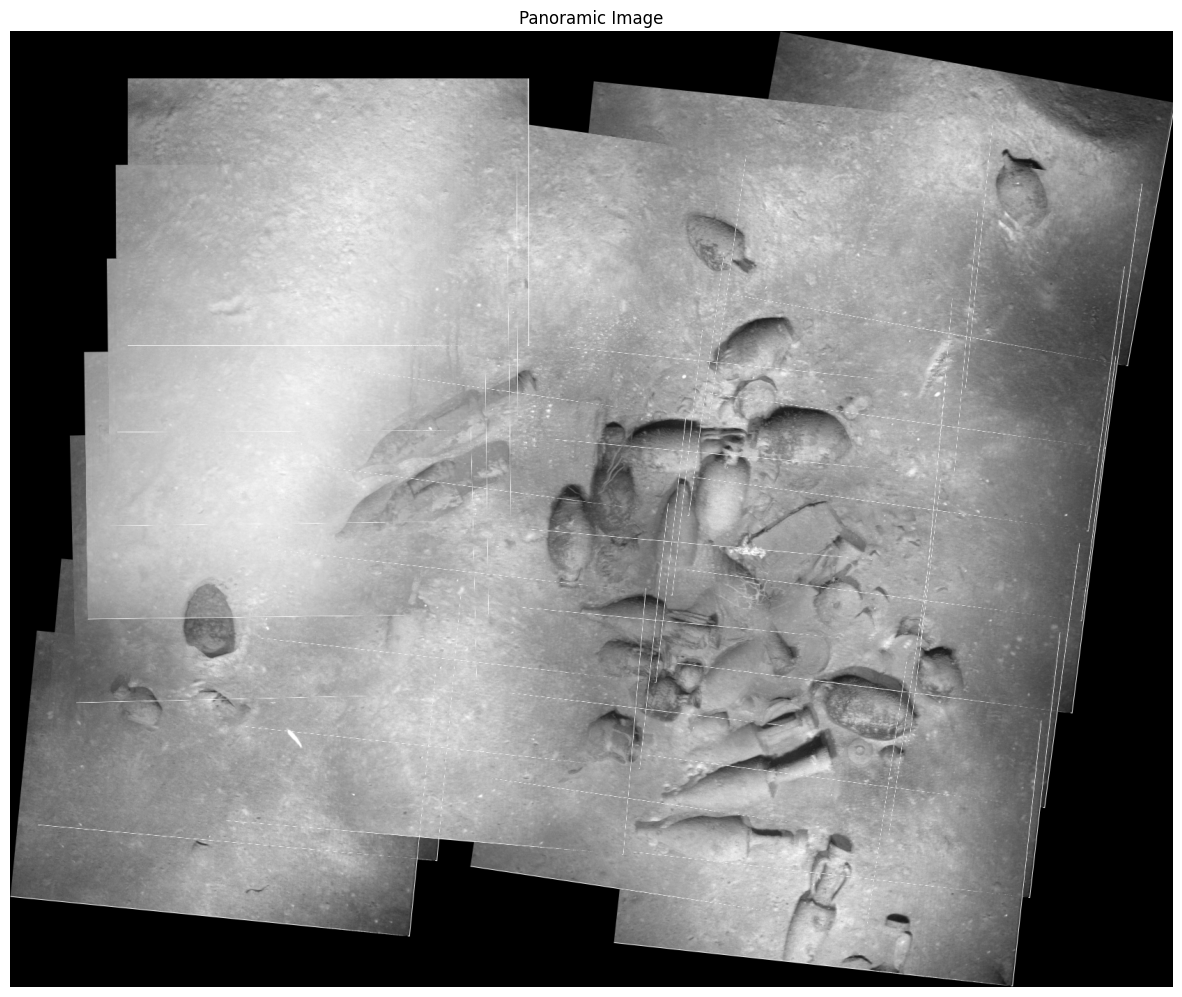

In [24]:
# Extract poses from optimized estimates
optimized_poses = gtsam.utilities.allPose2s(optimized_estimates)

# Calculate affine transformation matrices from optimized poses
affine_matrices = []
for i in range(len(pixel)):
    pose = optimized_poses.atPose2(i)
    affine_matrix = pose.matrix()
    
    # Create a translation matrix to center the image
    center_translation = np.eye(3)
    center_translation[:2, 2] = -np.array([img_width / 2, img_height / 2])
    
    # Combine affine matrix with center translation
    affine_matrices.append(affine_matrix @ center_translation)

# Create the panorama using the updated function
panorama = stitch_panorama(pixel, affine_matrices)

# Display the result
plt.figure(figsize=(15, 15))
plt.imshow(panorama)
plt.title('Panoramic Image')
plt.axis('off')
plt.show()

**The Final Stitch of the 28 images dataset is good enough, but it could be better. There are visible seams and edges same as in the case of 6 images. There is also significant blurring of one objects near the centre. This could be improved by applying exposure compensation to address brightness differences, and keypoint alignment needs to be rechecked to reduce blurring near the center.**